# Exercise 3 – Interpretation von Modellen

### c) Welche Charakteristika eines weiblichen Krebses in `crabs.txt` finden männliche Krebs (sogenannte Satellites auf Englisch) anziehend? Schätzen Sie die Anzahl der männlichen Krebse in Test-Datensatz anhand der Charakteristika der weiblichen Krebse. Baseline: Poisson Regression.

### Importieren der Bibliotheken

In [45]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  # for parallel coordinates
import sklearn.preprocessing  # for normalization

from module.poisson_regression import PoissonRegression
import sklearn.model_selection as ms

from sklearn import svm  # for SVM classification
from module.poisson_regression import PoissonRegression
from module.beta_regression import BetaRegression
from sklearn.model_selection import cross_val_score  # cross validation
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet, SGDRegressor
from sklearn.utils import shuffle

### Einlesen des Datensatzes

In [3]:
data = pd.read_csv('./data/crabs.txt', sep="\s+", header=None)  # whitespaces as seperators
data.columns = ["ID", "Color", "Spine", "Width", "Weight", "Sallite"]  # define column names

### Vertrautmachen mit den Daten

In [4]:
data.shape

(173, 6)

Die Daten umfassen 173 weibliche Pfeilschwanzkrebse. Zu jedem Krebs wird die Helligkeit (color), der Zustand des Rückens (spine), die Breite des Panzers (width), das Gewicht (weight) sowie die Anzahl der männlichen Anhänger (sallite) angegeben.

In [5]:
data = data.sort_values("Sallite", ascending=False)
data.head()  # show the crabs with most sallites

,ID,Color,Spine,Width,Weight,Sallite
100,101,2,3,28.3,3.00,15
47,48,2,1,26.0,2.30,14
158,159,4,3,29.3,3.23,12
132,133,2,3,28.2,3.05,11
60,61,2,3,29.0,3.20,10


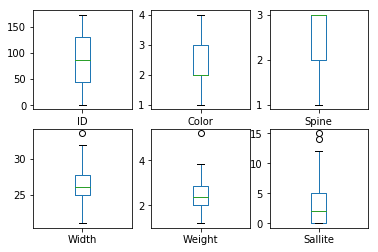

In [6]:
data.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False);  # show boxplots

Die Kraben mit den meisten männlichen Anhängern haben in der Regel eine Durchschnittliche Färbung, der Zustand des Rückens ist gut, der Panzer relativ breit und das Gewicht relativ hoch. Um einen besseren Überblick zu schaffen werden im Folgenden parallele Koordinaten und eine Scatter-Matrix dargestellt.

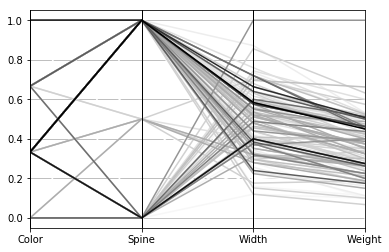

In [8]:
x = data.values
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)  # transform all variables into uniform range between 1 and 0
scaledData = pd.DataFrame(x_scaled)
scaledData.columns = data.columns
scaledData=scaledData.sort_values('Sallite')

ax = pd.plotting.parallel_coordinates(scaledData, 'Sallite', cols=["Color", "Spine", "Width", "Weight"], colormap='Greys')
ax.legend().remove()

Die Daten werden vor der Darstellung in den Bereich zwischen 0 und 1 transformiert, damit man Unterschiede bestmöglich erkennen kann. Alle Spalten nutzen dieselbe Skalierung. Krabben mit einer höheren Anzahl von Männchen entsprechen dunkelere Linien in den parallelen Koordinaten.

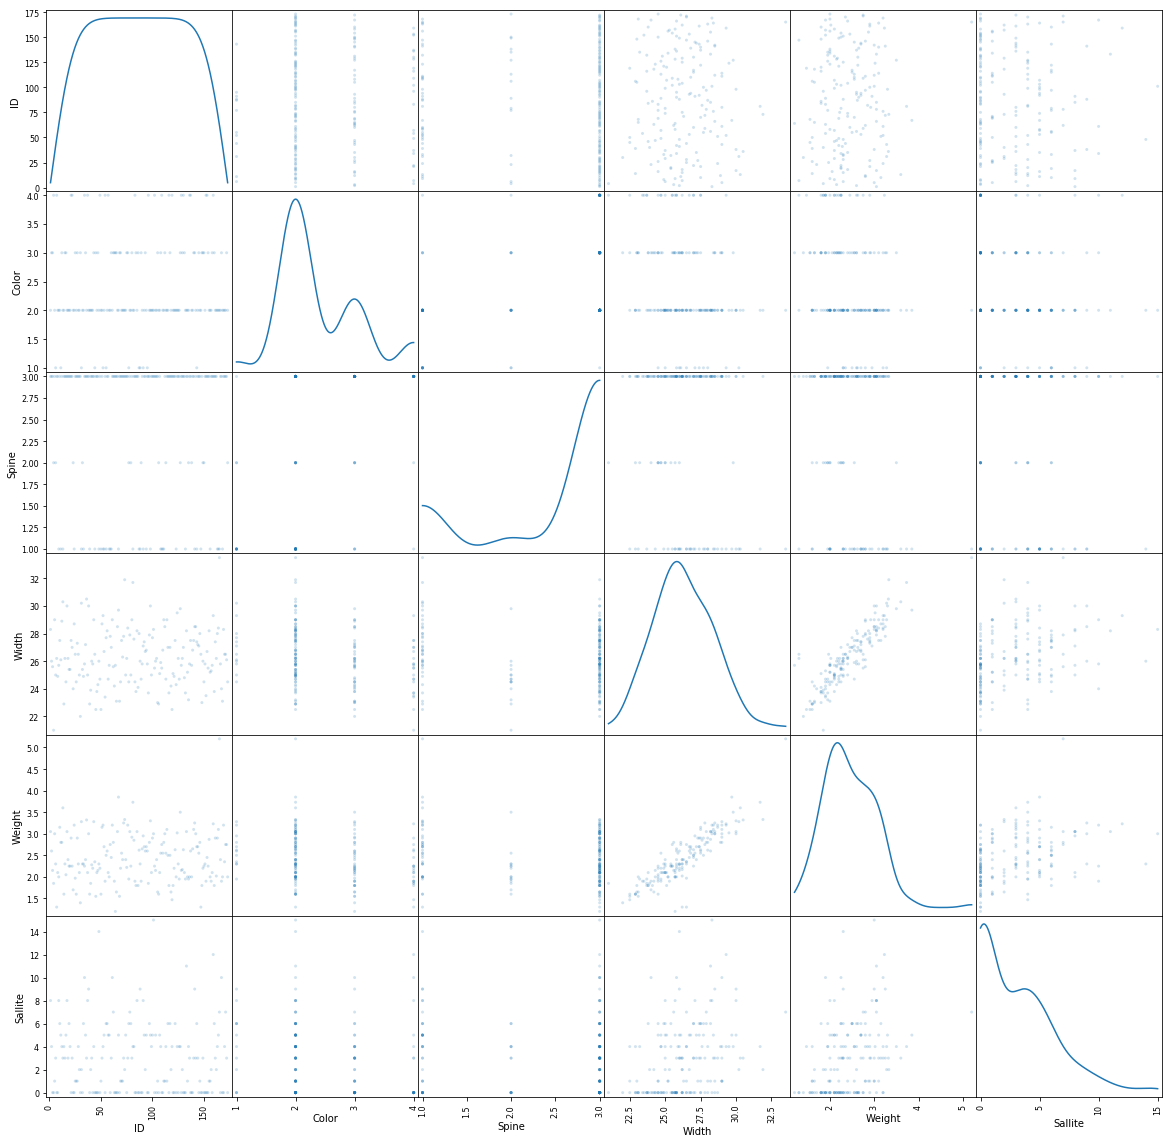

In [9]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal='kde');

Es lässt sich klar eine Korrelation zwischen der Breite und dem Gewicht der Krabben erkennen. Die meisten Krabben haben nur wenige Partner, wenige Krabben haben sehr viele, bis zu 15, Männchen.

### Schätzen der Anzahl männlicher Krebse

In [32]:
data = data.sample(frac=1).reset_index(drop=True) # shuffle data before split
X, y = data.values[:,:-1], data.values[:,-1]

Es handelt sich um ein Regressionsproblem bei dem die Anzahl der männlichen Krebse anhand der anderen Größen geschätzt werden muss. $y$ bezeichnet die tatsächliche Anzahl der männlichen Krebse. $X$ ist die Matrix mit allen anderen Größen. Die Schätzungen werden im Folgenden mit Crossvalidation und dem negativen durchschnittlichen quadratischem Fehler validiert. Letzterer bestraft größere Abweichungen stärker als es die $L1$-Norm tuen würde.

In [29]:
reg = PoissonRegression()
scores = cross_val_score(reg, X, y, cv=6, scoring='neg_mean_squared_error')
np.average(scores)

Optimization terminated successfully.
         Current function value: 2.697856
         Iterations 9
Optimization terminated successfully.
         Current function value: 2.585291
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.561402
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.546598
         Iterations 9
Optimization terminated successfully.
         Current function value: 2.615561
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.624967
         Iterations 10


-9.295011666516443

Für die Poisson-Regression wurde eine Klasse erstellt die gemäß dem Adapter-Entwurfsmuster ermöglicht die Scikitlearn Crossvalidierung zu verwenden. Sie basiert auf die Poisson-Regressionsimplementierung von dem Paket $statsmodels$. Es wird ein durchschnittlicher quadrierter Fehler von ungefähr 9,3 erreicht.

In [30]:
C_range = [1e-2, 1e-1, 1, 10]
for C in C_range:
    reg = svm.SVR(kernel='linear',C=C)  # SVR=regression
    scores = cross_val_score(reg, X, y, cv=6, scoring='neg_mean_squared_error')
    print("C: "+str(C)+" score: "+str(np.average(scores)))

C: 0.01 score: -9.24594221762149
C: 0.1 score: -9.090501353378434
C: 1 score: -9.131544054718335
C: 10 score: -9.081397674082465


Als Alternative zur Poisson-Regression wird die Regression mittels linearer SVMs versucht. Es wird für den Hyperparameter unterschiedliche Werte ausprobiert. Ein höheres C kommt anscheindend der Performance zugute. Mit einem quadratischen Fehler von ungefähr 11.78 wird der Fehler von der Poisson-Regression schon unterboten.

In [31]:
regs = [Lasso(alpha=0.1), SGDRegressor(max_iter=1000, tol=1e-3), ElasticNet()]
for reg in regs:
    scores = cross_val_score(reg, X, y, cv=6, scoring='neg_mean_squared_error')
    print(np.average(scores))

-8.85908395087637
-2.7705412009278815e+25
-8.897065124947977


# TODO ? Andere Regressions-Modelle schneiden nicht so gut ab, wie die zuvor vorgestellten.

In [33]:
reg = svm.SVR(kernel='linear', C=10) # train "optimal" linear SVM for visualization  
reg.fit(X, y)
data["prediction"] = reg.predict(X)  # predict the values adding them to the data frame
data.sort_values("prediction").head()

,ID,Color,Spine,Width,Weight,Sallite,prediction
137,119,4,3,22.5,1.47,4,-1.107417
111,152,4,3,23.5,1.90,0,-0.531569
142,116,4,3,23.7,1.80,0,-0.410563
168,96,4,3,23.7,1.85,0,-0.191775
155,7,4,3,26.2,1.30,0,-0.107155


In [34]:
data.sort_values("prediction").tail()

,ID,Color,Spine,Width,Weight,Sallite,prediction
128,81,2,1,31.7,3.73,4,5.073214
141,67,2,1,29.7,3.85,5,5.099001
80,13,2,1,30.3,3.60,3,5.162347
43,31,1,1,30.2,3.28,2,5.293326
46,165,2,1,33.5,5.20,7,7.032384


Das Modell der linearen SVM lernt, dass die Farbe relativ niedrig sein muss, genau wie der Rücken. Die Breite und das Gewicht müssen relativ groß sein, damit das Weibchen viele Männchen hat.

### d) Schätzen Sie den Anteil des Rohöls im Test-Datensatz, das in Gasolin konvertiert wird, anhand anderer Indikatoren im Datensatz `gasoline.csv`. Baseline: Beta Regression

### Einlesen der Daten

In [35]:
data = pd.read_csv('./data/gasoline.csv', sep=";", decimal=",")

### Vertrautmachen mit den Daten

In [36]:
data.shape

(32, 7)

In [39]:
data.describe()

,Unnamed: 0,yield,gravity,pressure,temp10,temp,batch
count,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000
mean,16.500000,0.196594,39.250000,4.18125,241.500000,332.093750,5.250000
std,9.380832,0.107224,5.635429,2.61983,37.541375,69.755961,2.884888
min,1.000000,0.028000,31.800000,0.20000,190.000000,205.000000,1.000000
25%,8.750000,0.116500,36.625000,1.80000,217.000000,274.500000,3.000000
50%,16.500000,0.178000,40.000000,4.80000,231.000000,349.000000,5.000000
75%,24.250000,0.270500,40.925000,6.10000,268.750000,383.000000,7.250000
max,32.000000,0.457000,50.800000,8.60000,316.000000,444.000000,10.000000


In [40]:
data.head()

,Unnamed: 0,yield,gravity,pressure,temp10,temp,batch
0,1,0.122,50.8,8.6,190,205,1
1,2,0.223,50.8,8.6,190,275,1
2,3,0.347,50.8,8.6,190,345,1
3,4,0.457,50.8,8.6,190,407,1
4,5,0.080,40.8,3.5,210,218,2


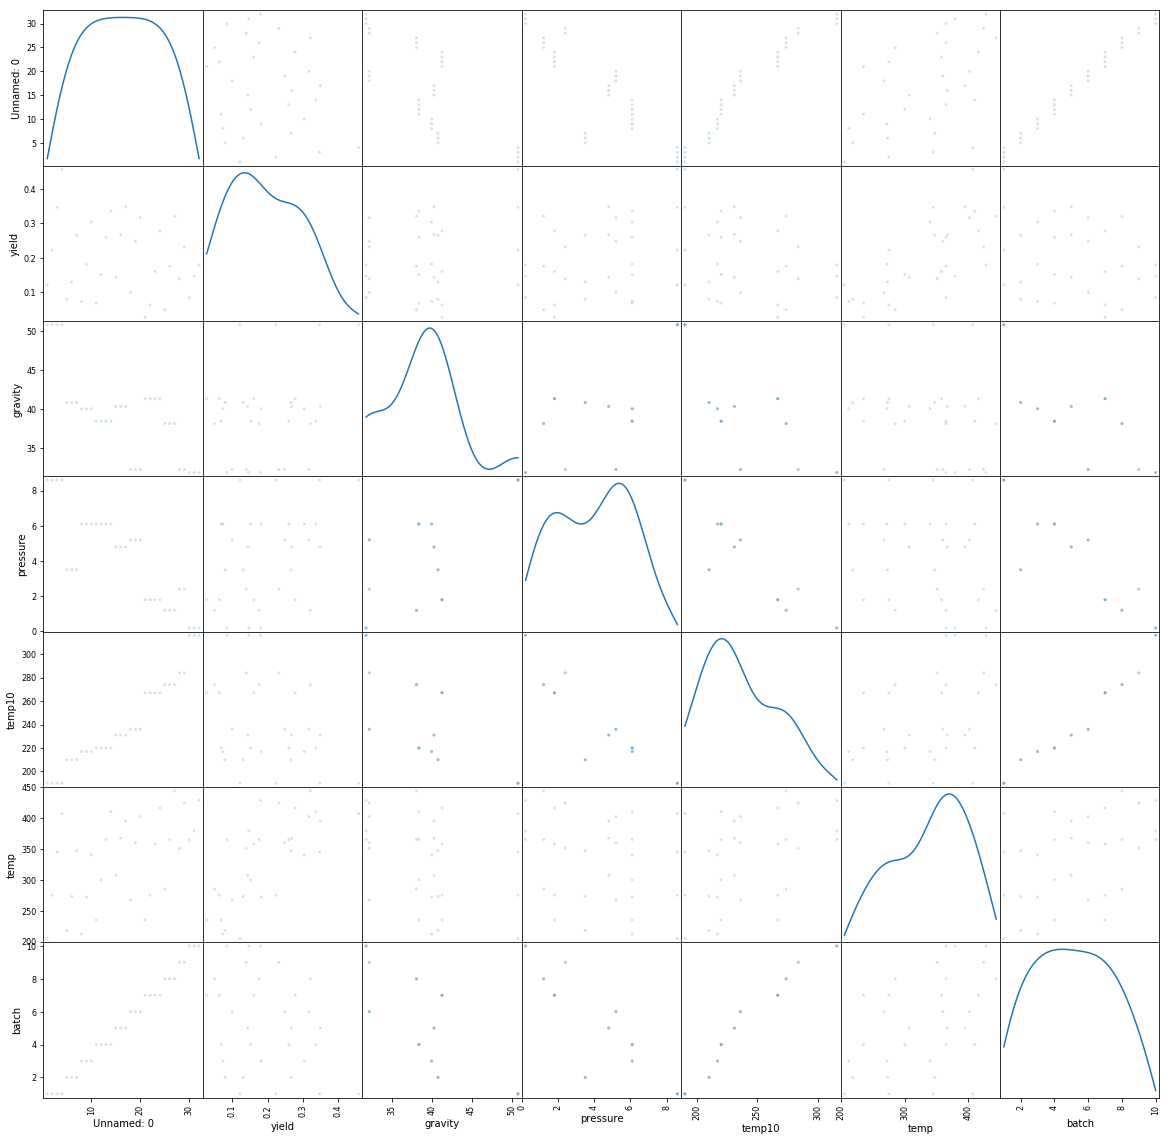

In [41]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal='kde'); # create boxplot

In [46]:
X, y = data.values[:,2:], data.values[:,1]
X, y = shuffle(X, y)

In [47]:
clf = BetaRegression()
scores = cross_val_score(clf, X, y, cv=2, scoring='neg_mean_squared_error')
np.mean(scores)

-0.009733189801520024

Das Modell der Beta-Regression wird analog zur Poisson-Regression mittels der $statsmodels$-Bibliothek implementiert und gemäß Adapter-Entwurfsmuster für die Evaluation kompatibel gemacht. Es ergibt sich ein mittlerer quadratischer Fehler von 0.0044.

In [48]:
C_range = [1e-2, 1e-1, 1, 10]  # SVM
for C in C_range:
    reg = svm.SVR(kernel='linear',C=C)  # SVR=regression
    scores = cross_val_score(reg, X, y, cv=2, scoring='neg_mean_squared_error')
    print("C: "+str(C)+" score: "+str(np.average(scores)))
    
scores = cross_val_score(ElasticNet(), X, y, cv=2, scoring='neg_mean_squared_error') # Elastic Net
np.mean(scores)

C: 0.01 score: -0.004828195705873834
C: 0.1 score: -0.004828195705873834
C: 1 score: -0.004828195705873834
C: 10 score: -0.004828195705873834


-0.0009859521979150307

Diesmal kommt die Lineare Regressio mittels SVM nicht an die Performance der Betaregression ran. Elastic-Net kann annähernd mit der Beta-Regression mithalten, doch muss sich auch geschlagen geben.

In [34]:
scores = cross_val_score(Lasso(alpha=0.1), X, y, cv=2, scoring='neg_mean_squared_error')
np.mean(scores)

-0.0012865896546306267

Die Lasso-Regression schlägt sich deutlich besser. Der Quadratische Fehler beträgt nur ungefähr ein viertel von dem der Beta-Regression.